In this script, we merge our dataframe with outcome variables (change in mme before and after August 2013) with the County Health Rankings database from University of Wisconsin Population Health Institute (linked here: https://www.countyhealthrankings.org/health-data/new-york/data-and-resources). As the number of features in comparison to observations is large, we apply recursive feature elimination to select for the most predictive variables and avoid overfitting our model. As there is an imbalance in outcomes within our dataset (41 counties decreased vs 9 increased), we also have applied synthetic minority oversampling technique when training the model.
We have also generated an ROC and classification matrix to help evaluate performance of the model in this script.

# Preparing and merging datasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
county_health_data = pd.read_csv("/content/drive/MyDrive/HED challenge/dataset w  filtered drugs, pharmacies, and mme conversion/county health data 2013.csv")
county_health_data.head()

,County,Population,< 18,65 and over,African American,American Indian/ Alaskan Native,Asian,Native Hawaiian/ Other Pacific Islander,Hispanic,Non-hispanic white,...,Mentally Unhealthy Days,Motor Vehicle Mortality Rate,% Uninsured.1,PCP Rate,Preventable hospital stays rate,% Unemployed,% No Social-Emotional Support,Violent Crime Rate,% Limited Access,% Fast Foods
0,NaN,19465197,22.0,13.7,14.6,1.0,7.8,0.1,18.0,58,...,3.4,7.0,14,82,66,8.2,24.0,391,2,45
1,Albany,303565,19.5,14.1,12.1,0.3,5.1,0.1,5.2,76,...,3.1,7.0,10,93,62,7.0,20.0,422,5,47
2,Allegany,48778,21.2,15.5,1.2,0.3,1.0,0.0,1.4,95,...,3.5,16.0,12,33,75,8.7,18.0,214,3,39
3,Bronx,1392002,26.5,10.7,30.0,2.9,4.2,0.4,53.8,11,...,3.8,4.0,17,47,81,12.3,34.0,576,0,63
4,Broome,199031,19.9,16.6,4.6,0.2,3.6,0.1,3.5,86,...,3.8,8.0,12,80,62,8.5,20.0,254,5,47


In [ ]:
county_health_data['County'] = county_health_data['County'].str.upper()
county_health_data = county_health_data.iloc[1:]
county_health_data = county_health_data.drop(county_health_data.columns[1], axis=1)
county_health_data.head()

,County,< 18,65 and over,African American,American Indian/ Alaskan Native,Asian,Native Hawaiian/ Other Pacific Islander,Hispanic,Non-hispanic white,# not proficient in English,...,Mentally Unhealthy Days,Motor Vehicle Mortality Rate,% Uninsured.1,PCP Rate,Preventable hospital stays rate,% Unemployed,% No Social-Emotional Support,Violent Crime Rate,% Limited Access,% Fast Foods
1,ALBANY,19.5,14.1,12.1,0.3,5.1,0.1,5.2,76,4922,...,3.1,7.0,10,93,62,7.0,20.0,422,5,47
2,ALLEGANY,21.2,15.5,1.2,0.3,1.0,0.0,1.4,95,157,...,3.5,16.0,12,33,75,8.7,18.0,214,3,39
3,BRONX,26.5,10.7,30.0,2.9,4.2,0.4,53.8,11,197328,...,3.8,4.0,17,47,81,12.3,34.0,576,0,63
4,BROOME,19.9,16.6,4.6,0.2,3.6,0.1,3.5,86,1746,...,3.8,8.0,12,80,62,8.5,20.0,254,5,47
5,CATTARAUGUS,23.1,15.6,1.3,3.2,0.7,0.0,1.8,92,550,...,3.0,15.0,14,45,90,8.7,25.0,245,2,34


In [ ]:
outcomes = pd.read_csv("/content/drive/MyDrive/HED challenge/dataset w  filtered drugs, pharmacies, and mme conversion/county_directions_percentchanges.csv")
outcomes = outcomes.drop(outcomes.columns[0], axis = 1)
outcomes.head()

,County Name,Trend Direction,Mean MME/Pop After,Mean MME/Pop Before,Absolute Change,Percentage Change
0,ALBANY,decreased,28.023322,115.593487,-87.570165,-75.757006
1,ALLEGANY,increased,35.998743,22.785193,13.213550,57.991828
2,BRONX,decreased,25.757088,101.304826,-75.547738,-74.574668
3,BROOME,decreased,61.004665,86.934795,-25.930130,-29.827102
4,CATTARAUGUS,neutral,43.504494,66.984211,-23.479718,-35.052615


Merging outcomes with County Health Rankings Data

In [ ]:
df = pd.merge(county_health_data, outcomes, left_on= ['County'], right_on= ["County Name"], how = "left")
df.drop('County Name', axis = 1, inplace = True)
df.head()

,County,< 18,65 and over,African American,American Indian/ Alaskan Native,Asian,Native Hawaiian/ Other Pacific Islander,Hispanic,Non-hispanic white,# not proficient in English,...,% Unemployed,% No Social-Emotional Support,Violent Crime Rate,% Limited Access,% Fast Foods,Trend Direction,Mean MME/Pop After,Mean MME/Pop Before,Absolute Change,Percentage Change
0,ALBANY,19.5,14.1,12.1,0.3,5.1,0.1,5.2,76,4922,...,7.0,20.0,422,5,47,decreased,28.023322,115.593487,-87.570165,-75.757006
1,ALLEGANY,21.2,15.5,1.2,0.3,1.0,0.0,1.4,95,157,...,8.7,18.0,214,3,39,increased,35.998743,22.785193,13.213550,57.991828
2,BRONX,26.5,10.7,30.0,2.9,4.2,0.4,53.8,11,197328,...,12.3,34.0,576,0,63,decreased,25.757088,101.304826,-75.547738,-74.574668
3,BROOME,19.9,16.6,4.6,0.2,3.6,0.1,3.5,86,1746,...,8.5,20.0,254,5,47,decreased,61.004665,86.934795,-25.930130,-29.827102
4,CATTARAUGUS,23.1,15.6,1.3,3.2,0.7,0.0,1.8,92,550,...,8.7,25.0,245,2,34,neutral,43.504494,66.984211,-23.479718,-35.052615


In [ ]:
print(df['Trend Direction'].value_counts())

Trend Direction
decreased    41
neutral      10
increased     9
Name: count, dtype: int64


In [ ]:
df = df[df['Trend Direction'].notna()]
df_filtered = df[df['Trend Direction'] != 'neutral'].copy()

df_filtered['binary'] = df_filtered['Trend Direction'].map({'increased': 1, 'decreased': 0})

df_filtered.iloc[:, 1:31] = df_filtered.iloc[:, 1:31].apply(lambda x: x.fillna(x.mean()), axis=0)

print(df_filtered.head())


     County  < 18  65 and over  African American  \
0    ALBANY  19.5         14.1              12.1   
1  ALLEGANY  21.2         15.5               1.2   
2     BRONX  26.5         10.7              30.0   
3    BROOME  19.9         16.6               4.6   
5    CAYUGA  21.2         15.5               4.0   

   American Indian/ Alaskan Native  Asian  \
0                              0.3    5.1   
1                              0.3    1.0   
2                              2.9    4.2   
3                              0.2    3.6   
5                              0.4    0.6   

   Native Hawaiian/ Other Pacific Islander  Hispanic  Non-hispanic white  \
0                                      0.1       5.2                  76   
1                                      0.0       1.4                  95   
2                                      0.4      53.8                  11   
3                                      0.1       3.5                  86   
5                                   

In [ ]:
df_filtered['Trend Direction'].value_counts()
df_filtered.shape

(50, 37)

Applying SMOTE and RFE, then fitting model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

outcome_columns = ['binary', 'Trend Direction', 'Mean MME/Pop After', 'Mean MME/Pop Before',
                   'Absolute Change', 'Percentage Change', 'County']
X = df_filtered.drop(columns=outcome_columns)
Y = df_filtered['binary']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=16)

#applying SMOTE
smote = SMOTE(random_state=16)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=500)

#applying RFE
n_features_to_select = 6
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
rfe.fit(X_train_scaled, y_train_smote)  # Use the resampled and scaled data

selected_features = X.columns[rfe.support_]

print("Selected Features:", X.columns[rfe.support_])


Selected Features: Index(['African American', 'American Indian/ Alaskan Native',
       'Native Hawaiian/ Other Pacific Islander', '% diabetic',
       '% Fair/Poor Health', '% Limited Access'],
      dtype='object')


In [ ]:
from sklearn.metrics import accuracy_score, log_loss, f1_score

X_train_selected = X_train_scaled[:, rfe.support_]
X_test_selected = X_test_scaled[:, rfe.support_]

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_selected, y_train_smote)

y_pred = logreg.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)


Accuracy on test set: 0.7


In [ ]:
coefficients = logreg.coef_[0]
selected_feature_names = X_train.columns[rfe.support_]

print("\nFeature Coefficients:")
for feature, coef in zip(selected_feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")


Feature Coefficients:
African American: -1.4829
American Indian/ Alaskan Native: -1.1448
Native Hawaiian/ Other Pacific Islander: 0.8624
% diabetic: 1.0307
% Fair/Poor Health: -0.6974
% Limited Access: 1.0716


Generating the classifcation matrix

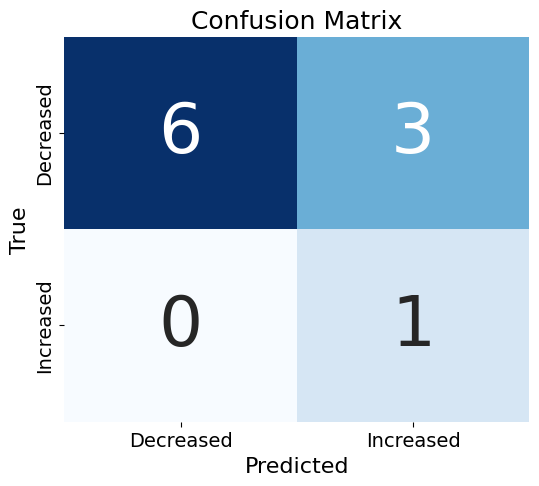

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            annot_kws={"size": 50},
            xticklabels=['Decreased', 'Increased'],
            yticklabels=['Decreased', 'Increased'], ax=ax)


ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16)
ax.set_title('Confusion Matrix', fontsize=18)


ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.show()



Generating an ROC curve

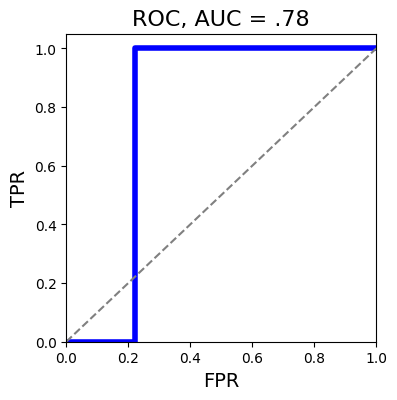

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

X_test_scaled_selected = rfe.transform(X_test_scaled)

y_prob = logreg.predict_proba(X_test_scaled_selected)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', lw=4)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.title('ROC, AUC = .78', fontsize=16)

plt.show()



In [ ]:
import statsmodels.api as sm
import numpy as np

X_train_selected_with_intercept = sm.add_constant(X_train_selected)

logreg_sm = sm.Logit(y_train_smote, X_train_selected_with_intercept)
logreg_sm_fit = logreg_sm.fit()

print("\nFeature Coefficients and their p-values:")
summary = logreg_sm_fit.summary2().tables[1]
for feature, coef, p_value in zip(selected_feature_names, logreg_sm_fit.params[1:], logreg_sm_fit.pvalues[1:]):
    print(f"{feature}: Coefficient = {coef:.4f}, p-value = {p_value:.4f}")



Optimization terminated successfully.
         Current function value: 0.308850
         Iterations 9

Feature Coefficients and their p-values:
African American: Coefficient = -3.1104, p-value = 0.0122
American Indian/ Alaskan Native: Coefficient = -2.9569, p-value = 0.1021
Native Hawaiian/ Other Pacific Islander: Coefficient = 2.1202, p-value = 0.0305
% diabetic: Coefficient = 1.8937, p-value = 0.0034
% Fair/Poor Health: Coefficient = -1.0464, p-value = 0.0326
% Limited Access: Coefficient = 1.7467, p-value = 0.0216


Evaluating the logistic regression model through precision, recall, F1, and accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

X_test_selected_with_intercept = sm.add_constant(X_test_selected)

y_pred_prob = logreg_sm_fit.predict(X_test_selected_with_intercept)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_prob)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluation Metrics:
Accuracy: 0.7000
Precision: 0.2500
Recall: 1.0000
F1 Score: 0.4000
Log-loss: 0.9861


Generating odds ratios from each coefficient in the logistic regression model

In [ ]:
import numpy as np

coefficients = {
    'African American': -3.1104,
    'American Indian': -2.9569,
    'Pacific Islander': 2.1202,
    '% Diabetic': 1.8937,
    '% Fair/Poor Health': -1.0464,
    '% Limited Access': 1.7467
}

odds_ratios = {feature: np.exp(coef) for feature, coef in coefficients.items()}

for feature, odds_ratio in odds_ratios.items():
    print(f"Odds Ratio for {feature}: {odds_ratio:.4f}")


Odds Ratio for African American: 0.0446
Odds Ratio for American Indian: 0.0520
Odds Ratio for Pacific Islander: 8.3328
Odds Ratio for % Diabetic: 6.6439
Odds Ratio for % Fair/Poor Health: 0.3512
Odds Ratio for % Limited Access: 5.7356


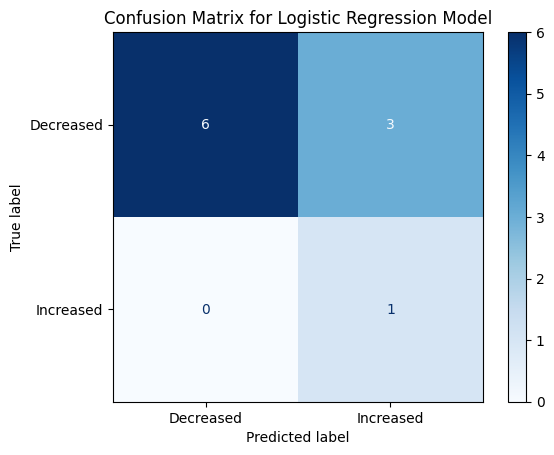

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = logreg.predict(X_test_selected)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Decreased', 'Increased'])
disp.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix for Logistic Regression Model')

plt.show()


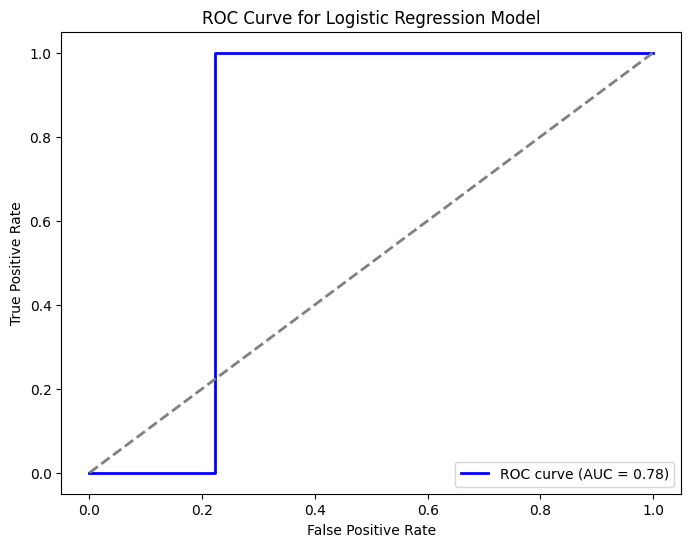

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_prob = logreg.predict_proba(X_test_selected)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random classifier)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend(loc='lower right')

plt.show()


Examining residual distribution

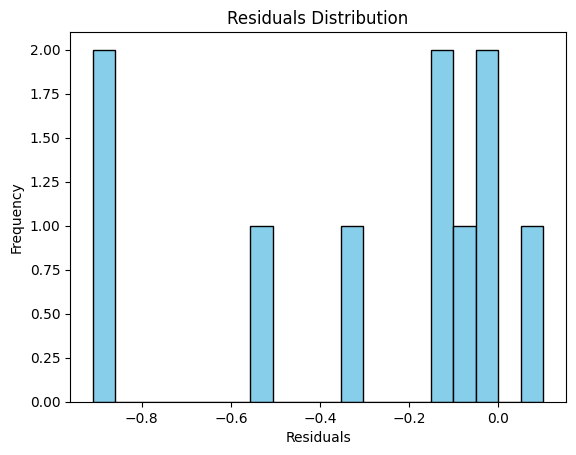

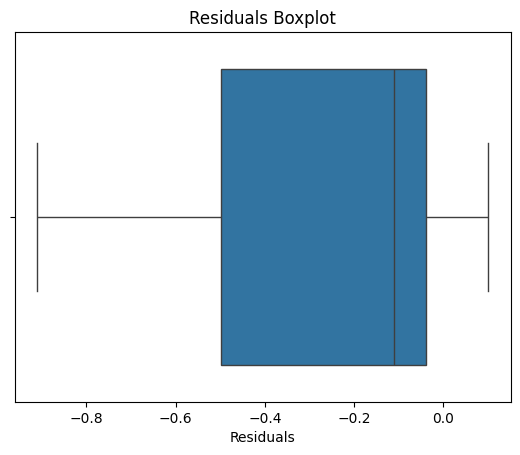

Mean Residual: -0.2936249536374008
Variance of Residuals: 0.13894906299348786


In [ ]:
y_prob_positive = y_prob[:, 1]

residuals = y_test - y_prob_positive

import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(residuals, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

sns.boxplot(x=residuals)
plt.xlabel("Residuals")
plt.title("Residuals Boxplot")
plt.show()


mean_residual = residuals.mean()
variance_residual = residuals.var()
print(f"Mean Residual: {mean_residual}")
print(f"Variance of Residuals: {variance_residual}")
